# Introduction

Nathan L. Hendel

BMI 203 Final Project

version 2

16 April 2016

Disclaimers: I worked closely with Daniel Asarnow and Cole Helsell. Together we discussed ideas and shared some snippets of code.

First, we import useful packages. Scikit-learn did most of the heavy lifting, it has different choices for learning machines.


In [2]:
#import statements
from __future__ import division
from __future__ import print_function
import sys
import os
import os.path
import time
import random
import numpy as np
import scipy as sp
import sklearn.datasets
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.svm
import sklearn.metrics
import sklearn.ensemble
import sklearn.linear_model
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio import motifs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

Logistic function takes any real number as input and returns a value between 0 and 1. In this project, I used it to convert distance scores returned by the machine learning algorithm and convert it into probabilities.


In [5]:
def logistic(z):
    return 1 / (1 + np.exp(-z))

# Prediction of RAP1 binding sites

We are given three sets of sequences, one of positive examples, one of negative examples, and one of test (unknown) sequences. These three file parsing functions are based on code by Derek Britain.

In [6]:
def make_pos_list(directory):
    positives = []
    with open(directory) as file:
        for line in file:
            seq = Seq(line.rstrip(), IUPAC.unambiguous_dna)
            positives.append(seq)
    return positives


def make_neg_list(directory,per_seq,pos_sequences):
    negatives = []
    i=-1
    with open(directory) as file:
        for line in file:
            
            if line[0] == '>':
                i+=1
                continue
                
            if len(negatives) == i:
                negatives.append(line.rstrip())
                
            else:
                negatives[i]+=line.rstrip()
    
    #randomly draw sequences from master negative list
#     subset = random.sample(negatives, number_seq)
    selection = []
    
    #grab a 17mer from each sequence in the list
    for i in range(0, per_seq):
        for seq in negatives:
            point = random.randint(17,len(seq))
            candidate = Seq(seq[point-17:point], IUPAC.unambiguous_dna)

            #check if the sequence is a perfect match with a known positive
            if candidate not in pos_sequences:
                selection.append(candidate)  
        
    return selection

def make_test_data(directory):
    sequences = []
    with open(directory) as file:
        for line in file:
            seq = Seq(line.rstrip(), IUPAC.unambiguous_dna)
            #create list of tuples with sequences and True output
            sequences.append(seq)
    return sequences

## Sequence analysis
In this section, I analyze the example sequences in preparation for converting them into a good training set for a machine learning algorithm.


In [76]:
topdir = '/Users/student/Documents/UCSF/algorithms/final-project/'
test_seq = make_test_data(os.path.join(topdir, 'rap1-lieb-test.txt'))
pos = make_pos_list(os.path.join(topdir,'rap1-lieb-positives.txt'))
neg = make_neg_list(os.path.join(topdir, 
         'yeast-upstream-1k-negative.fa'), 10, set(pos + test_seq))

Here we use the concept of the position-specific scoring matrix (PSSM). This is a 4xK matrix, where K is the length of the sequence, and 4 is for the number of nucleotides (A,G,C,T). The values are the frequencies of each nucleotide at each position in the positive example set. The PSSM score takes an input sequence and sums the values for the population frequency of each nucleotide in the input sequence. I used a BioPython motif object to simply calculation.

In [77]:
rap1 = motifs.create(pos)
pssm = rap1.counts.normalize(pseudocounts=0.5).log_odds()
neg_pssm_scores = [pssm.calculate(x) for x in neg]
pos_pssm_scores = [pssm.calculate(x) for x in pos]
test_pssm_scores = [pssm.calculate(x) for x in test_seq]
pos_scores = np.array([[pssm[char][i] for i, char in enumerate(p)] for p in pos], ndmin=2)
neg_scores = np.array([[pssm[char][i] for i, char in enumerate(p)] for p in neg], ndmin=2)
test_scores = np.array([[pssm[char][i] for i, char in enumerate(p)] for p in test_seq], ndmin=2)
neg_sidx = sorted(np.arange(len(neg)), key=lambda i: neg_pssm_scores[i], reverse=True)

Here is a visualization of the PSSM scores. Notice that there is no overlap between negative examples and positive examples. Also notice that the test sequence scores are in between the negative examples and the positive examples. This means that to train our machine learning algorithm, we must curate our training set to include the negative examples most similar to positive examples.

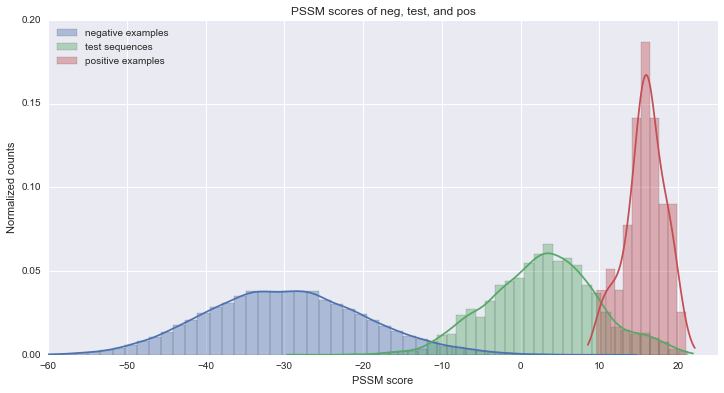

In [78]:
plt.figure(figsize=(12,6))
sns.distplot(neg_pssm_scores, label='negative examples');
sns.distplot(test_pssm_scores, label='test sequences');
sns.distplot(pos_pssm_scores, label='positive examples');
plt.xlim((-60, 25));
plt.title('PSSM scores of neg, test, and pos');
plt.legend(loc=2);
plt.xlabel('PSSM score');
plt.ylabel('Normalized counts');

Here I begin to prepare the training data for the machine learning algorithm. One obstacle is that we have substantially more negative examples than positive. If the algorithm trained on all the data we have, it would be overloaded with negative examples and have trouble deciding a sequence is positive. To avoid this problem, I have chosen to use 200 negative sequences to accompany the 100 positives we were given in the training set.

To solve the issue of the significant space in PSSM score between negative examples and positive examples, I chose to use the 100 negative examples with the highest PSSM score. My negative set is 100 random negative sequences and 100 high-PSSM scoring negative sequences.

In [79]:
N_pos=100
N_neg=200 #total number of negatives
N_topneg = 100

pos_idx = np.random.choice(np.arange(len(pos)), N_pos, replace=False)
pos_labels = np.zeros(len(pos), dtype = bool)
pos_labels[pos_idx] = True

neg_idx = np.concatenate([neg_sidx[:N_topneg], 
                         np.random.choice(neg_sidx[N_topneg:], N_neg-N_topneg, replace=False)])

# neg_idx = np.random.choice(np.arange(len(neg)), N_neg, replace=False)

neg_labels = np.zeros(len(neg), dtype = bool)
neg_labels[neg_idx] = True

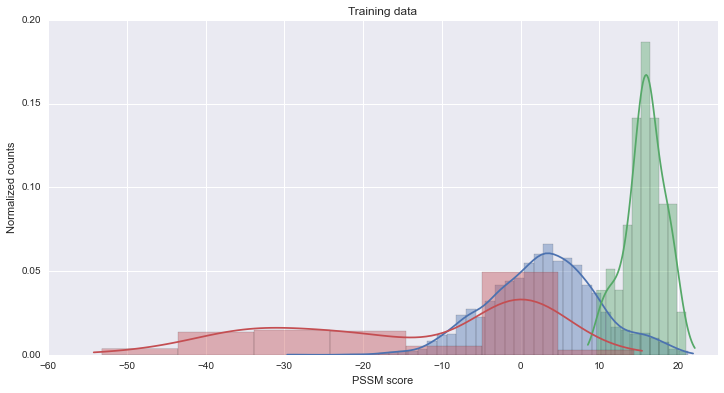

In [80]:
bot = [neg[i] for i in neg_idx]

n_pssm_scores = [pssm.calculate(x) for x in bot]

plt.figure(figsize=(12,6))
#sns.distplot(neg_pssm_scores);
sns.distplot(test_pssm_scores, label = 'test');
sns.distplot(pos_pssm_scores, label = 'positive examples');
sns.distplot(n_pssm_scores, label = 'negative examples')
plt.xlim((-60, 25));
plt.title('Training data');
plt.xlabel('PSSM score');
plt.ylabel('Normalized counts');

## Preparing training set
### as bitstring 

The function below converts a sequence into a bitstring representation of the sequence. In this case, G is converted into 0001, T into 0010, A into 0100, and C into 1000. So the sequence 'AG' would become 01000001. With Daniel Asarnow and Cole Helsell, we thought about condensing the bitstring representations into two bit strings: 00, 10, 01, and 11. However we noticed that the distance between 00 and 11 is different than the distance between 00 and 10. We did not want to introduce this bias, so we settled on this 4-bit representation. This sequence-to-bitstring converter will be used later as part of the training set for the machine learning algorithm.

In [7]:
# convert sequences into array of 0s and 1s
def bitstring(seq):
    bs = np.zeros(len(seq)*4)
    nuc_dict = {'G': 3, 'T': 2, 'A': 1, 'C':0 }
    for i,nuc in enumerate(seq):
        bs[i*4+nuc_dict[nuc]] = 1
    return bs

In [26]:
pos_bits = np.array([bitstring(i) for i in pos])
neg_bits = np.array([bitstring(i) for i in neg])
test_bits = np.array([bitstring(i) for i in test_seq])

Here I prepare the training data, called "entry", and whether each sequence is positive or negative, represented as an array of booleans called "labels". 

In [40]:
entry = np.concatenate([pos_bits[pos_labels], neg_bits[neg_labels]], axis=0)
labels = np.concatenate([np.ones(len(pos_idx), dtype=bool), np.zeros(len(neg_idx), dtype=bool)])

### as bitstring with PSSM score

This is an alternate version of the training set with the PSSM score concatenated onto the bitstring vector. This representation of the example sequence may improve performance. PSSM scores are good indicators of sequence similarity, and perhaps it is a useful metric that is not redundant with the sequence in bitstring format. If it is not useful, the algorithm should down-weight it.

In [74]:
pos_bitpssm = np.concatenate([pos_bits, pos_scores], axis=1)
neg_bitpssm = np.concatenate([neg_bits, neg_scores], axis=1)
test_bitpssm = np.concatenate([test_bits, test_scores], axis=1)

entry_bitpssm = np.concatenate([pos_bitpssm[pos_labels], neg_bitpssm[neg_labels]], axis=0)

## Machine Learning with SVM

I used an Support Vector Machine from the scikit learn package in Python. This is a supervised learning model used for classification. The SVM receives training data and places them in a graph. It then creates a division between the positive and negative training set.The machine learns by adjusting its division to be that with the highest minimum distance to the training examples. When given a point to classify, the SVM places it in the graph and then measures the distance between the point and the division.  This distance can be easily converted into a score between 0 and 1 by using the logisitic function defined earlier.


The Linear SVM uses a hyperplane with the number of dimensions as the input data. This works well, however the general SVM works better, because its division shape is more flexible. I use sklearn.svm.SVC to use support vector clustering. I use the default radial basis function kernel, which allows us to easily compute distances between points in high dimesional space. The kernel allows us to skip placing each test point in the high-dimensional graph by essentially computing dot products between the test point and points in the training set. This is different than a neural network, which creates a set of weights that adjust to form good prediction.

### Cross-Validation
For cross-validation, I am using the scikit-learn method `cross_validation`. This splits up the training data into sections to train on and sections to test. I use `StratifiedKFold`, which divides the training set into `k` subsets, where each element of the training data is in exactly one subset. I then iterate over each of these subsets and train the network on the data not in the subset, and then predict the values of the subset. This method results in an array called `label_pred` with prediction values for each value in the training set. The display of the next cell is the confusion matrix, which shows the true positives (upper left), false positives (upper right), false negatives (lower left), and false negatives (lower right). There are very few false positives and true positives, which shows that the SVM performs well.

### Training on bitstrings only

In [68]:
k=5
skf=sklearn.cross_validation.StratifiedKFold(labels,k)

label_pred = np.empty(len(labels))
label_dec = np.empty(len(labels))

for train_idx, test_idx in skf:
    clf=sklearn.svm.SVC(C=3)
    clf.fit(entry[train_idx,:], labels[train_idx])
    label_pred[test_idx] = clf.predict(entry[test_idx,:])
    
cm = sklearn.metrics.confusion_matrix(labels,label_pred)
cm

array([[197,   3],
       [  2,  98]])

In [70]:
ypred_all = np.empty(len(labels))
ydec_all = np.empty(test_bits.shape[0])

svm_all = sklearn.svm.SVC(C=3,kernel='rbf')
# Train classifier.
svm_all.fit(entry, labels)
# Test classifier.
ypred_all = svm_all.predict(test_bits)
ydec_all = logistic(svm_all.decision_function(test_bits))


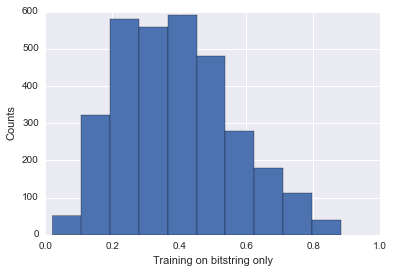

In [84]:
plt.hist(ydec_all);
plt.xlim(0,1);
plt.xlabel('Score');
plt.ylabel('Counts');
plt.xlabel('Training on bitstring only');

In [150]:
with open('seq_score_2.txt', 'w') as f:
    for i in range(len(test_seq)):
        string = str(test_seq[i])+'\t%s' %ydec_all[i]+'\n'
        f.write(string)

### Training on bitstrings with PSSM

In [53]:
k=5
skf=sklearn.cross_validation.StratifiedKFold(labels,k)

label_pred_bitpssm = np.empty(len(labels))
label_dec_bitpssm = np.empty(len(labels))

for train_idx, test_idx in skf:
    clf_bitpssm=sklearn.svm.SVC(C=3)
    clf_bitpssm.fit(entry_bitpssm[train_idx,:], labels[train_idx])
    label_pred_bitpssm[test_idx] = clf_bitpssm.predict(entry_bitpssm[test_idx,:])
    
cm_bitpssm = sklearn.metrics.confusion_matrix(labels,label_pred_bitpssm)
cm_bitpssm

array([[196,   4],
       [  1,  99]])

In [54]:
ydec_all2 = np.empty(test_bitpssm.shape[0])
svm_all2 = sklearn.svm.SVC(C=3,kernel='rbf')

# Train classifier.
svm_all2.fit(entry_bitpssm, labels)

# Test classifier.
ydec_all2 = logistic(svm_all2.decision_function(test_bitpssm))

# ydec_all = svm_all.predict_proba(test_bits)
ydec_all2

array([ 0.1513889 ,  0.17851332,  0.28197562, ...,  0.18730222,
        0.1705663 ,  0.25326356])

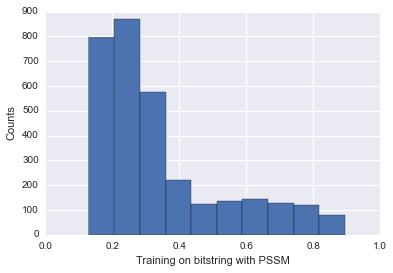

In [91]:
plt.hist(ydec_all2);
plt.xlim(0,1);
plt.xlabel('Score');
plt.ylabel('Counts');
plt.xlabel('Training on bitstring with PSSM');

In [28]:
with open('nathendel_scores.txt', 'w') as f:
    for i in range(len(test_seq)):
        string = str(test_seq[i])+'\t%s' %ydec_all2[i]+'\n'
        f.write(string)

## Additional cross-validation
Since I am turning in this version of my project after the due date, I was able to use my classmates' results as a guide. Daniel Asarnow's algorithm had an ROC curve with a score of 0.97, so I compared my results with his. I generated an ROC curve for my own score predictions using his predictions as the truth. The results here will not be as accurate as an ROC curve with the actual truth values for each test sequence, however it should be fairly close.

In [49]:
import csv
da=[]
with open('ann_predictions_da.txt') as g:
    for line in csv.reader(g, dialect="excel-tab"):
        da.append(bool(round(float(line[1]))))
da = np.array(da)

In [72]:
tpr = []
fpr = []

for thresh in np.arange(0,1.01,.01):
    nh = ydec_all>thresh
    tpr.append(np.sum(da & nh).astype(np.double) / np.sum(da))
    fpr.append(np.sum(nh & ~da).astype(np.double) / np.sum(~da))    

Area under ROC = 0.87660640573


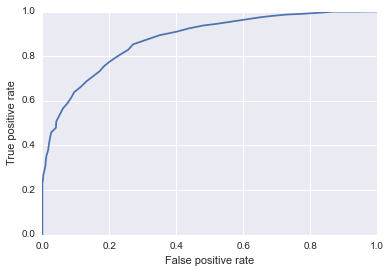

In [73]:
plt.plot(fpr,tpr);
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print('Area under ROC =', sp.trapz(tpr[::-1],fpr[::-1]))

Next I used the output of the network using bitstrings plus PSSM scores as training and compared my results with Daniel's.

Area under ROC = 0.911724114855


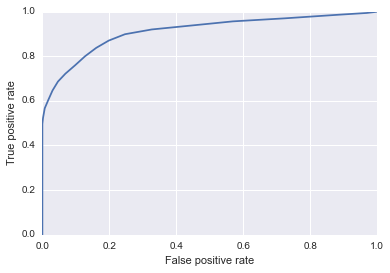

In [66]:
tpr2 = []
fpr2 = []

for thresh in np.arange(0,1.01,.01):
    nh2 = ydec_all2>thresh
    tpr2.append(np.sum(da & nh2).astype(np.double) / np.sum(da))
    fpr2.append(np.sum(nh2 & ~da).astype(np.double) / np.sum(~da))  
    
plt.plot(fpr2,tpr2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
print('Area under ROC =', sp.trapz(tpr2[::-1],fpr2[::-1]))

This improved ROC score indicates -- but again, does not prove -- that the addition of the PSSM score to the training data improves the network's predictive ability. From this, I decided to turn in the bitstring+PSSM trained SVM's predictions on the test set.

If you have any questions, feel free to contact me at nat.hendel@gmail.com